# Working with Coastal Radar Data

This project is a demonstration of how to read, subset and visualize HF radar data.  Another goal of this project is to compare with the geostrophic current velocities estimated from satellite altimeter sea level anomaly data and the CMEMS global analysis. 



In [1]:
from netCDF4 import Dataset
import netCDF4 as netcdf
import numpy as np
from matplotlib import pyplot as plt, animation
%matplotlib inline

import matplotlib.ticker as mticker
import matplotlib as mpl
import cmocean as cmo

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.interpolate import griddata

import xarray as xr
import xarray.ufuncs as xu

from datetime import datetime
from matplotlib.path import Path
from matplotlib.patches import Polygon
from matplotlib import rc
font = {'weight':'bold'}
rc('font',**font)

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display
#import geoviews as gv
#import holoviews as hv
#import geoviews.feature as gf
#gv.extension('bokeh', 'matplotlib')

## Download HFR data

The HF Radar dataset, specifically the IOOS HFRADAR US East and Gulf Coast 6km Resolution Hourly RTV dataset, can be accessed at the dataset's THREDDS catalog:

https://hfrnet-tds.ucsd.edu/thredds/HFRADAR_USEGC.html

Since its size is about 100 GB, it is more efficient to read and select the parameters of interest rather than downloading it. However, it may take a few minutes for subsetting the dataset. Therefore, a small sample of the dataset is saved as netcdf and used for this notebook.

In [2]:
# import HFR dataset
aggr_url = "https://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd"
data_h = xr.open_dataset(aggr_url)

## Satellite Altimetry 

The satellite altimeter dataset used is XTRACK which is dedicated for coastal applications.

https://www.aviso.altimetry.fr/index.php?id=3047

This notebook focuses on the Mid Atlantic bight. The along-track 228 from the Jason 3 (a successor of Topex Poseidon, Jason 1 and 2) cycle 157 was selected but the same process can be followed for any altimeter track from the XTRACK (or other along track datasets).


track figure

figure of comparison for one hour, speed 

## CMEMS Model Output

Information about the Copernicus Marine Environmental Monitoring Service (CMEMS) global analysis forecast model can be found here:
https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_ANALYSIS_FORECAST_PHY_001_024

Please note that the global analysis system is not assimilating the US East Coast HF radar observations.


In [3]:
# import CMEMS outputs
aggr_url = "./data/CMEMS-global-analysis-forecast-phy-001-024-hourly-u-v.nc"
data_m = xr.open_dataset(aggr_url)

In [4]:
## COMPARE THE CMEMS MODEL AND THE RADAR OBSERVATIONS

In [5]:
# subset the dataset to the area and time period of interest

lonw, lone = -76.3, -73   # westernmonst and easternmost longitude
lats, latn = 36.5, 39.5 # southernmonst and northernmost latitude
date1 = "2020-05-01"    # initial date
date2 = "2020-06-01"    # final date

# create mask
mask_lon = (data_h.lon >= lonw) & (data_h.lon <= lone)
mask_lat = (data_h.lat >= lats) & (data_h.lat <= latn)

# subset
%time data_sub_h = data_h.sel(time=slice(date1, date2)).where(mask_lon & mask_lat, drop=True)

CPU times: user 484 ms, sys: 172 ms, total: 656 ms
Wall time: 19.6 s


In [6]:
mask_lon = (data_m.longitude >= lonw) & (data_m.longitude <= lone)
mask_lat = (data_m.latitude >= lats) & (data_m.latitude <= latn)
%time data_sub_m = data_m.sel(time=slice(date1, date2)).where(mask_lon & mask_lat, drop=True)

#data.groupby("time.month").mean(dim='time')
#data_sub # 'subseted' dataset

CPU times: user 35.5 ms, sys: 2.82 ms, total: 38.4 ms
Wall time: 37.8 ms


In [7]:
data_sub_m # 

<xarray.Dataset>
Dimensions:    (time: 744, depth: 1, latitude: 37, longitude: 37)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 36.5 36.58 36.67 36.75 ... 39.33 39.42 39.5
  * time       (time) datetime64[ns] 2020-05-01T00:30:00 ... 2020-05-31T23:30:00
  * longitude  (longitude) float32 -76.0 -75.92 -75.83 ... -73.17 -73.08 -73.0
Data variables:
    vo         (time, depth, latitude, longitude) float32 nan 0.4047 ... -0.047
    uo         (time, depth, latitude, longitude) float32 nan ... -0.04151
Attributes: (12/25)
    title:                              hourly mean fields from Global Ocean ...
    easting:                            longitude
    northing:                           latitude
    history:                            2021/08/05 00:11:43 MERCATOR OCEAN Ne...
    source:                             MERCATOR PSY4QV3R1
    institution:                        MERCATOR OCEAN
    ...                                 ...
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              0.494025
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [8]:
# select a specific date and time
date = '2020-05-05T09:00:00'
datah = data_sub_h.sel(time=date,method='nearest')
datam = data_sub_m.sel(time=date,method='nearest') # mimics the model output - to be merged with Teresa and Maurício's code
# need to import the satellite data s well

In [9]:
datah, datam = data_sub_h, data_sub_m

In [10]:
# calculate the magnitude of surface currents
Magh = np.sqrt(datah.u**2+datah.v**2)
Magm = np.sqrt(datam.uo**2+datam.vo**2)

# create the mesh
xh, yh = np.meshgrid(datah.lon.values,datah.lat.values)
xm, ym = np.meshgrid(datam.longitude.values,datam.latitude.values)

# mask data
Magh = np.ma.masked_invalid(Magh)
Magm = np.ma.masked_invalid(Magm).squeeze()
Uh = np.ma.masked_invalid(datah.u.values)
Vh = np.ma.masked_invalid(datah.v.values)
Um = np.ma.masked_invalid(datam.uo.values).squeeze()
Vm = np.ma.masked_invalid(datam.vo.values).squeeze()

In [11]:
#Angleh = np.pi/2 - np.arctan2(Uh/Magh, Vh/Magh)
#Anglem = np.pi/2 - np.arctan2(Um/magm, Vm/Magm)

In [12]:
def make_map(lonw,lone,lats,latn,ax,flag=0):
    ax.set_extent([lonw, lone, lats, latn])

    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    stp = 1
    lon_ticks = np.around(np.arange(int(lonw),int(lone)+stp),1) #[-75, -74, -73, -72, -71, -70, -69]
    lat_ticks = np.around(np.arange(lats,latn+stp),1)

    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    ax.xaxis.set_tick_params(which='major', size=2., width=1, 
                             direction='in', top='on', pad=7)
    ax.yaxis.set_tick_params(which='major', size=2., width=1, 
                             direction='in', right='on',pad=7)
    
    if flag == 0: ax.tick_params(labelleft=True,labelbottom=True,labeltop=False,labelright=False)  
    elif flag == 1: ax.tick_params(labelleft=False,labelbottom=True,labeltop=False,labelright=False)  
    else: ax.tick_params(labelleft=False,labelbottom=True,labeltop=False,labelright=True)  

    ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='.5', alpha=0.4)
    ax.coastlines(resolution='10m',linewidth=0.3)
    return ax

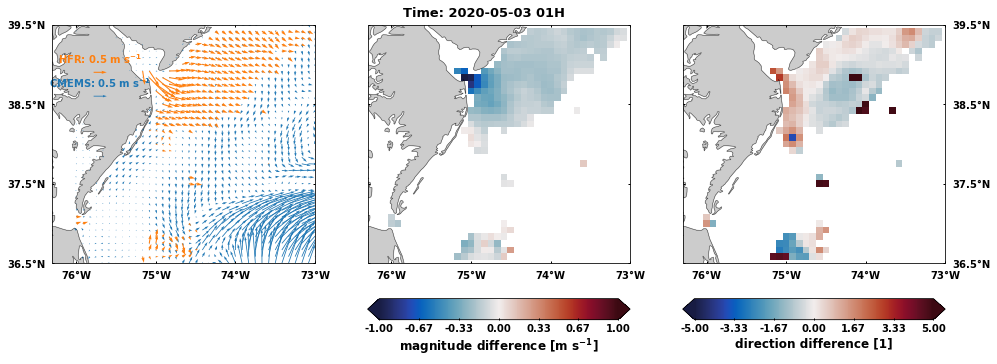

In [13]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(13,3)
i = 49
proj = ccrs.PlateCarree()
#ax = fig.add_subplot(1,3,1,projection=proj)
fig = plt.figure(1,figsize=(16,6))
ax1 = fig.add_subplot(gs[:12,0],projection=proj)
ax2 = fig.add_subplot(gs[:12,1],projection=proj)
ax3 = fig.add_subplot(gs[:12,2],projection=proj)
ax4 = fig.add_subplot(gs[12,1])
ax5 = fig.add_subplot(gs[12,2])
ax1 = make_map(lonw,lone,lats,latn,ax1,flag=0)

uh = griddata((xh.ravel(),yh.ravel()),Uh[i].ravel(),(xm,ym))
vh = griddata((xh.ravel(),yh.ravel()),Vh[i].ravel(),(xm,ym))
magh = griddata((xh.ravel(),yh.ravel()),Magh[i].ravel(),(xm,ym))

um, vm, magm = Um[i], Vm[i], Magm[i]
angleh = np.pi/2 - np.arctan2(uh/magh, vh/magh)
anglem = np.pi/2 - np.arctan2(um/magm, vm/magm)

# plot current vectors
c1, c2 = 'C1', 'C0'
cf1=ax1.quiver(xm,ym,uh,vh,color=c1,#magh,cmap=cmo.cm.tempo,
             scale=10,width=.004,zorder=2)
cf2=ax1.quiver(xm,ym,um,vm,color=c2,#magm,cmap=cmo.cm.amp,
             scale=10,width=.003,zorder=1)

# add the scale for the currents magnitude
qk = ax1.quiverkey(cf1, -75.7, 38.9, 0.5, label='HFR: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='data', labelcolor=c1)
qk = ax1.quiverkey(cf2, -75.7, 38.6, 0.5, label='CMEMS: 0.5 m s$^{-1}$', labelpos='N',
                   coordinates='data', labelcolor=c2)

# time stamp
the_time = np.datetime_as_string(datah.time.values[i], unit='h')#'%Y-%m-%d')
the_time = the_time[:10]+' %sH'%the_time[11:]
#ax1.text(-75.6,39.25,'Time: {:}'.format(the_time),fontsize=13,va='center', ha='center',
#        bbox=dict(facecolor='w', alpha=.6),transform=proj)
fig.suptitle('Time: {:}'.format(the_time),fontsize=13,fontweight='bold',y=.85)


#ax = fig.add_subplot(1,3,2,projection=proj)
ax2 = make_map(lonw,lone,lats,latn,ax2,flag=1)
cf = ax2.pcolormesh(xm,ym,magm-magh,vmin=-1,vmax=1,cmap=cmo.cm.balance)
#cax,kw = mpl.colorbar.make_axes(ax2,location='bottom',pad=0.05,aspect=5)
out=fig.colorbar(cf,cax=ax4,ticks=np.linspace(-1,1,7),
                 format='%.2f',extend='both',orientation='horizontal')
out.set_label('magnitude difference [m s$^{-1}$]',size=12,fontweight='bold')
out.ax.tick_params(direction='in',size=2., width=1)

#ax = fig.add_subplot(1,3,3,projection=proj)
ax3 = make_map(lonw,lone,lats,latn,ax3,flag=2)
cf = ax3.pcolormesh(xm,ym,anglem-angleh,vmin=-5,vmax=5,cmap=cmo.cm.balance)

out=fig.colorbar(cf,cax=ax5,ticks=np.linspace(-5,5,7),
                 format='%.2f',extend='both',orientation='horizontal')
out.set_label('direction difference [1]',size=12,fontweight='bold')
out.ax.tick_params(direction='in',size=2., width=1)
#out.ax.tick_params(direction='in',size=2., width=1)
#print(i)
plt.show()
plt.close()
